In [24]:
import torch
import torch.nn as nn
from torch import optim

from unet import UNet
from torch.utils.data import DataLoader, random_split
from utils.dataset import BasicDataset
#from utils.dataset_h5 import BasicDataset

from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import transforms
import numpy as np

print('librerias importadas')

librerias importadas


In [25]:
# definimos algunos hiperparametros:
epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
val_percent = 0.2
img_scale = 1
dir_img = 'data_dm_overlapping/imgs/'
dir_mask = 'data_dm_overlapping/masks/'
batch_size = 5
lr = 0.001

# definimos el dataset:
dataset = BasicDataset(dir_img, dir_mask, img_scale, transforms=transforms.Compose([
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.114, 0.114, 0.114],std=[0.237, 0.237, 0.237])
                                                                ]), mask_h5=True)

# definimos los tamaños de los datasets de train, validation y test:
n_val = int(len(dataset) * val_percent)
n_test = n_val
n_train = len(dataset) - n_val - n_test
train, val, test = random_split(dataset, [n_train, n_val, n_test])
#n_train = len(dataset) - n_val
#train, val = random_split(dataset, [n_train, n_val])

# definimos los mini batch loaders:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

In [26]:
# resumen del conjunto de datos:
print(f'Total images: {len(dataset)}')
print('-'*20)
print(f'Training images: {len(train)}')
print(f'Validation images: {len(val)}')
print(f'Test images: {len(test)}')
print(f'Training batches: {len(train_loader)}')
print('-'*20)
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Total images: 3000
--------------------
Training images: 1800
Validation images: 600
Test images: 600
Training batches: 360
--------------------
Validation batches: 120
Test batches: 120


torch.Size([5, 3, 256, 256])
torch.Size([5, 1, 256, 256])


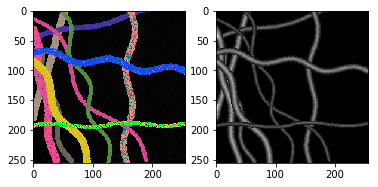

In [38]:
# mostramos un par: imagen, ground truth
lote = next(iter(train_loader))

print(lote['image'].shape)
print(lote['mask'].shape)

unnormalize = transforms.Normalize(mean=[-0.114/0.237, -0.114/0.237, -0.114/0.237],std=[1/0.237, 1/0.237, 1/0.237])
lote_img = unnormalize(lote['image'][0]).numpy().transpose(1,2,0)
#print(lote_img.max())

#plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(lote_img)
plt.subplot(122), plt.imshow(lote['mask'][0][0], cmap='gray')
plt.show()

In [ ]:
# Entrenamiento

# definimos el modelo:
net = UNet(n_channels=3, n_classes=1, bilinear=False)
net.to(device=device)

# hiperparametros del modelo:
criterion = nn.MSELoss()
#optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# historial de perdidas:
train_losses = []
val_losses = []

best_prec1 = 1e6

for epoch in range(epochs):
    net.train()
    epoch_loss = 0

    #with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
    with tqdm(total=n_train, desc=f'Train epoch {epoch+1}/{epochs}') as pbar:
        for batch in train_loader:
            imgs, true_masks = batch['image'], batch['mask']

            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=torch.float32)

            masks_pred = net(imgs)

            loss = criterion(masks_pred, true_masks)
            epoch_loss += loss.item() * imgs.size(0)

            pbar.set_postfix(**{'loss (batch)': loss.item()})

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            pbar.update(imgs.shape[0])

    train_losses.append(epoch_loss/len(train))

    # validacion
    net.eval()
    epoch_loss = 0
    
    with tqdm(total=n_val, desc=f'Val epoch {epoch+1}/{epochs}') as pbar:
        for batch in val_loader:
            imgs, true_masks = batch['image'], batch['mask']
            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=torch.float32)

            with torch.no_grad():
                mask_pred = net(imgs)
                loss = criterion(mask_pred, true_masks)

            epoch_loss += loss.item() * imgs.size(0)
        
            pbar.set_postfix(**{'loss (batch)': loss.item()})
            pbar.update(imgs.shape[0])
            
    scheduler.step(epoch_loss/len(val))
    val_losses.append(epoch_loss/len(val))
    
    # se guarda el modelo si es mejor que el anterior:
    prec1 = epoch_loss/n_val
    is_best = prec1 < best_prec1
    best_prec1 = min(prec1, best_prec1)
    
    if is_best:
        torch.save(net.state_dict(), 'MODEL.pth')
    
#print(f'The best MSE: {min(val_losses):.3f}')
print(f'The best MSE: {min(val_losses)}')

Train epoch 13/30:  72%|███████▏  | 1295/1800 [00:32<00:12, 39.55it/s, loss (batch)=0.0202] 

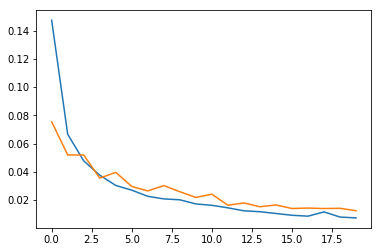

In [7]:
# curva de perdida:

import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
#torch.save(net.state_dict(), 'MODEL.pth')
#print(f'modelo guardado')

modelo guardado


torch.Size([5, 3, 256, 256])
ground truth


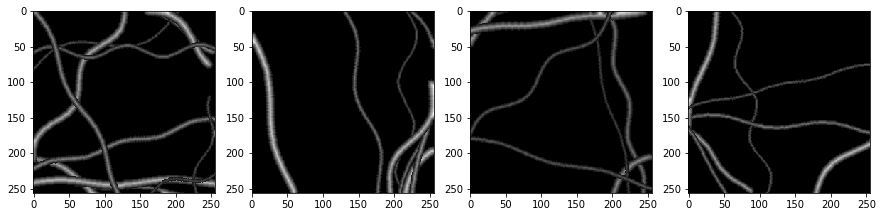

predictions


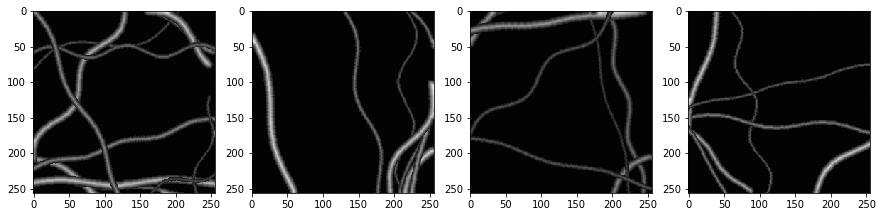

In [9]:
# mini batch de prueba

test_images = enumerate(test_loader)

q = next(test_images)

print(q[1]['image'].shape)

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(q[1]['mask'][i][0], cmap='gray')

print('ground truth')
plt.show()

side = 5
with torch.no_grad():
    output = net(q[1]['image'].cuda())
    
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(output.cpu()[i][0], cmap='gray')
    
print('predictions')
plt.show()

In [17]:
# creando una funcion de prediccion

from PIL import Image

# creamos la funcion de prediccion
def unet_dm(img_file, model_file='MODEL.pth'):
    '''
    Función de predicción
    '''
    img = Image.open(img_file)
    tf = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.114, 0.114, 0.114],std=[0.237, 0.237, 0.237])
                        ])
    img = tf(img)
    img = img.unsqueeze(0)
    #img.cuda()
    
    net = UNet(n_channels=3, n_classes=1, bilinear=False)
    #net.cuda()
    net.load_state_dict(torch.load(model_file))
    net.eval()
    
    with torch.no_grad():
        output = net(img)
        
    dm = output.squeeze().cpu().numpy()
    return dm



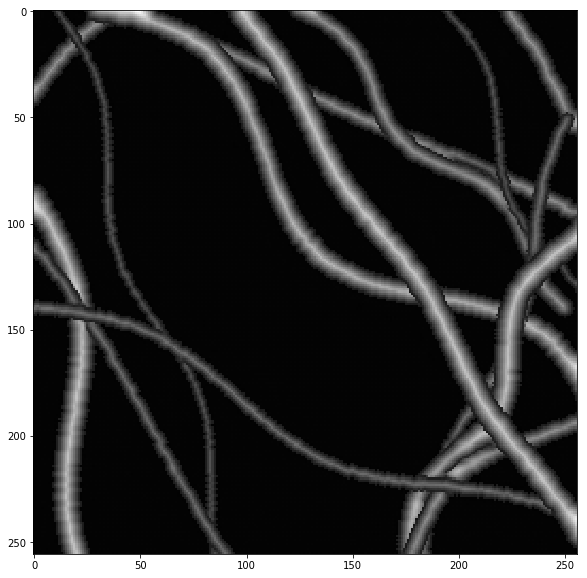

8.723575


In [20]:
import cv2

img_file = '0002.png'
predicted_dm = unet_dm(img_file)

plt.figure(figsize=(10,10))
plt.imshow(predicted_dm, cmap='gray')
plt.show()

print(predicted_dm.max())

### 